In [2]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib widget
import os
from scipy.signal import savgol_filter

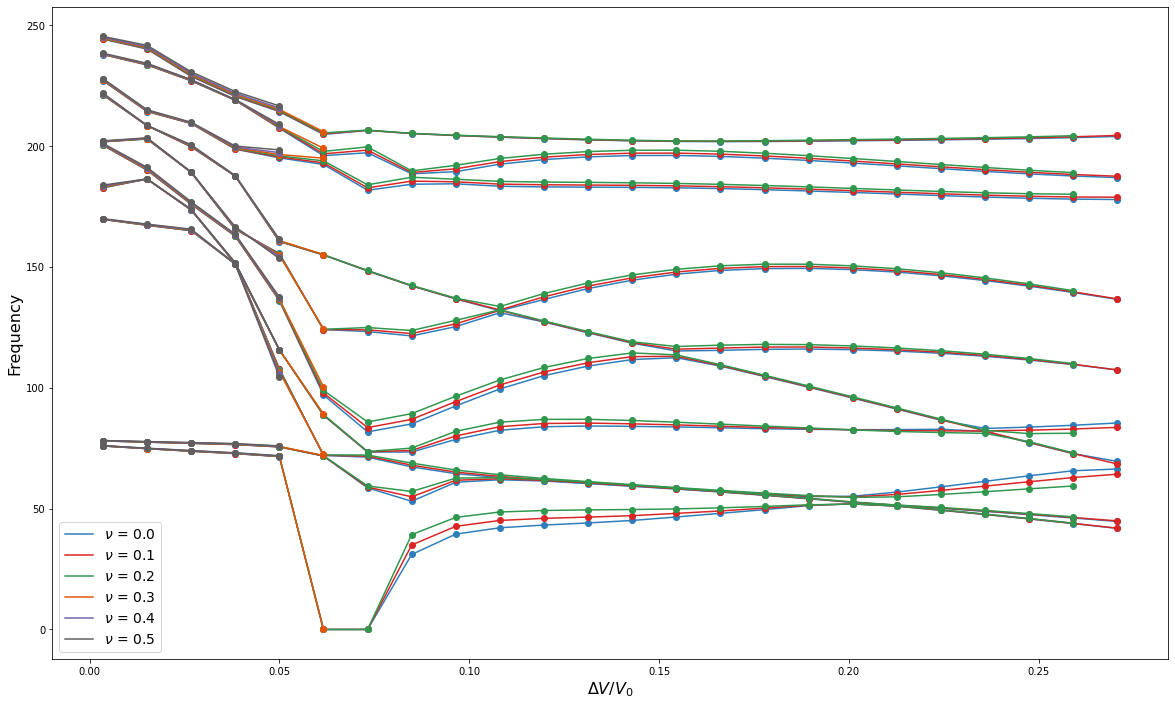

In [3]:
nu_try = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5]

# fig, ax = plt.subplots(figsize = (14,10))
fig, ax = plt.subplots(figsize = (20,12))

initial_idx = 400

cmap_all = ['Blues', 'Reds','Greens', 'Oranges', 'Purples', 'Greys', 'BuGn', 'YlOrBr', 'PuRd']

for i,nu in enumerate(nu_try):
    if nu >= 0.0:
        idx_cur = initial_idx + i
        data_path = f'data_out/bender-test_nu-{idx_cur}_eig_freq.txt'
        data_cur = np.loadtxt(data_path)
        temp_all = data_cur[:,0]
        freq_all = data_cur[:,1:]

        color_plot = plt.get_cmap(cmap_all[i])(0.7)

        for j in range(np.shape(freq_all)[1]):
            ax.plot(-3*temp_all, freq_all[:,j], 'o', color = color_plot)
            if j == 0:
                ax.plot(-3*temp_all, freq_all[:,j], '-', color = color_plot, label = rf'$\nu$ = {nu}')
            else:
                ax.plot(-3*temp_all, freq_all[:,j], '-', color = color_plot)



ax.legend(loc = 'best', fontsize = 14)
ax.set_xlabel('$\Delta V/V_0$', fontsize = 16)
ax.set_ylabel('Frequency', fontsize = 16)


fig.savefig('data_processed/change_nu_bender_freq.jpg')
